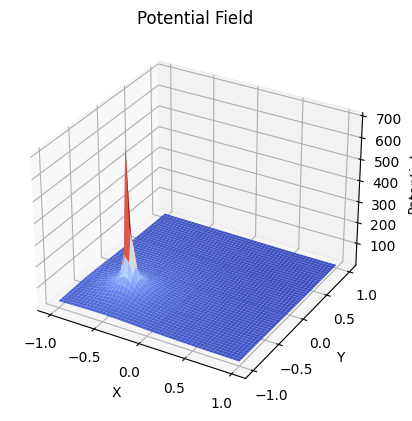

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the size of the grid
N = 50

# Create a meshgrid
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)

# Define the goal position
goal = np.array([0.5, 0.5])

# Define the obstacle position
obstacle = np.array([-0.5, -0.5])

# Define the strength of the goal and obstacle potentials
k_goal = 5
k_obstacle = 10

# Calculate the potential field
U_goal = k_goal * np.sqrt((X - goal[0])**2 + (Y - goal[1])**2)
U_obstacle = k_obstacle / np.sqrt((X - obstacle[0])**2 + (Y - obstacle[1])**2)
U = U_goal + U_obstacle

# Plot the potential field
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
ax.set_title('Potential Field')
plt.show()


In [2]:
import sys
sys.path.append('../')
import lidar_tool

path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1017_1852/vehicle.tesla.model3.master/velodyne_semantic/0000001577.bin'
lidar_tool.vis_pt(path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


FileNotFoundError: [Errno 2] No such file or directory: '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1017_1852/vehicle.tesla.model3.master/velodyne_semantic/0000001577.bin'

In [3]:
import open3d as o3d
import numpy as np

# Load point cloud sample data

pre_point = np.fromfile(path, dtype=np.dtype([
                                       ('x', np.float32),
                                       ('y', np.float32),
                                       ('z', np.float32),
                                       ('CosAngle', np.float32),
                                        ('ObjIdx', np.uint32),
                                       ('ObjTag', np.uint32)
                                   ]) ,count=-1)
semantic_point = np.array([list(elem) for elem in pre_point])

pcd  = o3d.geometry.PointCloud()

# keep point -10<x<10, -10<y<10, 0<z<10

semantic_point = semantic_point[(semantic_point[:,0]>-10) & (semantic_point[:,0]<10) & (semantic_point[:,1]>-10) & (semantic_point[:,1]<10) & (semantic_point[:,2]>0) & (semantic_point[:,2]<10)]


pcd.points = o3d.utility.Vector3dVector(semantic_point[:,:3])

# Compute normal vectors for each point
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Estimate normal vectors for each face
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 3

# Extract the point coordinates and normals
points = np.asarray(pcd.points)
normals = np.asarray(pcd.normals)

# Concatenate the point coordinates and normals
data = np.concatenate((points, normals), axis=1)

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

# Get the cluster labels
labels = kmeans.labels_

# Print the number of points in each cluster
for i in range(n_clusters):
    print('Cluster {}: {} points'.format(i, np.sum(labels == i)))
    # Alpha形状算法提取点云表面
    # Compute the Alpha shape
alpha = 0.2
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)

print('Number of triangles: {}'.format(len(mesh.triangles)))

o3d.visualization.draw_geometries([mesh])




FileNotFoundError: [Errno 2] No such file or directory: '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1017_1852/vehicle.tesla.model3.master/velodyne_semantic/0000001577.bin'

In [4]:
import numpy as np
from pathlib import Path

def load_pre_label(gt_json_path):
    if Path(gt_json_path).exists():
        pred_box = []
        with open(gt_json_path, 'r') as fobj:

            for line in fobj:
                l = line.strip().split(" ")
                try:
                    cx, cy, cz, sx, sy, sz, yaw, tag, mesh_cnt, time = l[0], l[1],l[2], l[3],l[4], l[5],l[6], l[7], l[8], l[9], l[10]
                    box_data = list(map(float,[ cx, cy, cz, sx, sy, sz, yaw, mesh_cnt]))
                    pred_box.append(box_data)
                    print("[label_str]",line)
                except:
                    print("[entropy infos]",line)
                
        return pred_box

In [5]:
txt_path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1017_2155/vehicle.tesla.model3.master/velodyne_semantic/0000003232.txt'
import pandas as pd
df = pd.read_csv(txt_path, sep=" ", header=None)
df.columns = ["cx", "cy", "cz", "sx", "sy", "sz", "yaw", "tag", "mesh_cnt", "time"]
df.head()

# 去除最后一行
df = df[:-1]


In [6]:
import time
import numpy as np
k = 100
lambda_ = df['mesh_cnt'].values
x = df['cx'].values
y = df['cy'].values

tick = time.time()


lambda_[lambda_ == 0] = 1

z = k / (x**2 + y**2) * np.log(lambda_)
tan = np.arctan2(y, x)

z2 = z * np.exp(1j * tan)  # 使用复数表示z和tan的乘积

sum_z = np.sum(z2)
tan_z = np.angle(sum_z)  # 计算复数的幅角
res_z = np.sum(z)
print(time.time() - tick)
print(np.abs(sum_z), tan_z)  # 使用np.abs计算复数的模
print(res_z)


0.0004830360412597656
0.18408974322055047 -1.039864208702555
3.73323264236941


In [16]:
import os
import pandas as pd
import numpy as np

path_1 = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_0104_1949/vehicle.tesla.model3.master/velodyne_semantic'
path_2 = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_0104_2002/vehicle.tesla.model3.master/velodyne_semantic'
path_3 = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_0104_2016/vehicle.tesla.model3.master/velodyne_semantic'
path_4 = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_0104_2032/vehicle.tesla.model3.master/velodyne_semantic'
path_5 = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_0104_2056/vehicle.tesla.model3.master/velodyne_semantic'
paths = [path_1, path_2, path_3, path_4, path_5]
df = pd.DataFrame(columns=['cx', 'cy', 'cz', 'sx', 'sy', 'sz', 'yaw', 'tag', 'mesh_cnt', 'dist', 'idx'])

for path_item in paths:

    for filename in os.listdir(path_item):
        if filename.endswith(".txt"):
            try:
                data = pd.read_5csv(os.path.join(path_1, filename), sep=" ", header=None)
                data.columns = ["cx", "cy", "cz", "sx", "sy", "sz", "yaw", "tag", "mesh_cnt", "idx"]
                data = data[:-1]
                dist = np.sqrt(data['cx']**2 + data['cy']**2 + data['cz']**2)
                data['dist'] = dist
                row = pd.DataFrame(data.iloc[0]).T
                df = pd.concat([df, row], ignore_index=True)
            except:
                print(filename)
                continue
# for filename in os.listdir(path_2):
#     if filename.endswith(".txt"):
#         data = pd.read_csv(os.path.join(path_2, filename), sep=" ", header=None)
#         data.columns = ["cx", "cy", "cz", "sx", "sy", "sz", "yaw", "tag", "mesh_cnt", "idx"]
#         data = data[:-1]
#         dist = np.sqrt(data['cx']**2 + data['cy']**2 + data['cz']**2)
#         data['dist'] = dist
#         row = pd.DataFrame(data.iloc[0]).T
#         df = pd.concat([df, row], ignore_index=True)

# spilt the df by 'tag', totally 3 sub df, tag='Car', 'Bus', 'Truck'
car_df = df[df['tag'] == 'Car']
bus_df = df[df['tag'] == 'Bus']
truck_df = df[df['tag'] == 'Truck']

# change the type of 'cx', 'cy', 'cz', 'sx', 'sy', 'sz', 'yaw', 'mesh_cnt' into float
car_df['cx'] = car_df['cx'].astype(float)
car_df['cy'] = car_df['cy'].astype(float)
car_df['cz'] = car_df['cz'].astype(float)
car_df['sx'] = car_df['sx'].astype(float)
car_df['sy'] = car_df['sy'].astype(float)
car_df['sz'] = car_df['sz'].astype(float)
car_df['yaw'] = car_df['yaw'].astype(float)
car_df['mesh_cnt'] = car_df['mesh_cnt'].astype(float)
car_df['dist'] = car_df['dist'].astype(float)

bus_df['cx'] = bus_df['cx'].astype(float)
bus_df['cy'] = bus_df['cy'].astype(float)
bus_df['cz'] = bus_df['cz'].astype(float)
bus_df['sx'] = bus_df['sx'].astype(float)
bus_df['sy'] = bus_df['sy'].astype(float)
bus_df['sz'] = bus_df['sz'].astype(float)
bus_df['yaw'] = bus_df['yaw'].astype(float)
bus_df['mesh_cnt'] = bus_df['mesh_cnt'].astype(float)
bus_df['dist'] = bus_df['dist'].astype(float)

truck_df['cx'] = truck_df['cx'].astype(float)
truck_df['cy'] = truck_df['cy'].astype(float)
truck_df['cz'] = truck_df['cz'].astype(float)
truck_df['sx'] = truck_df['sx'].astype(float)
truck_df['sy'] = truck_df['sy'].astype(float)
truck_df['sz'] = truck_df['sz'].astype(float)
truck_df['yaw'] = truck_df['yaw'].astype(float)
truck_df['mesh_cnt'] = truck_df['mesh_cnt'].astype(float)
truck_df['dist'] = truck_df['dist'].astype(float)


0000015167.txt
0000015179.txt
0000015209.txt
0000013574.txt
0000015170.txt
0000015176.txt
0000015197.txt
0000015206.txt
0000013583.txt
0000013565.txt
0000015203.txt
0000015200.txt
0000015182.txt
0000013589.txt
0000015173.txt
0000013709.txt
0000013001.txt
0000015215.txt
0000015185.txt
0000015164.txt
0000013712.txt
0000015188.txt
0000012995.txt
0000013568.txt
0000013580.txt
0000015218.txt
0000013577.txt
0000013571.txt
0000015161.txt
0000013586.txt
0000015212.txt
0000015158.txt
0000013007.txt
0000013703.txt
0000013706.txt
0000012998.txt
0000013004.txt
0000015194.txt
0000012992.txt
0000015191.txt
0000021331.txt
0000022999.txt
0000021832.txt
0000021508.txt
0000023074.txt
0000022630.txt
0000021505.txt
0000021010.txt
0000021622.txt
0000021358.txt
0000020746.txt
0000023128.txt
0000020770.txt
0000022840.txt
0000021739.txt
0000021826.txt
0000022072.txt
0000021448.txt
0000022534.txt
0000023164.txt
0000023062.txt
0000022741.txt
0000020869.txt
0000021064.txt
0000023086.txt
0000021685.txt
0000022369

/tmp/ipykernel_361107/2897039804.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['cx'] = car_df['cx'].astype(float)
/tmp/ipykernel_361107/2897039804.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['cy'] = car_df['cy'].astype(float)
/tmp/ipykernel_361107/2897039804.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

/tmp/ipykernel_361107/2544161914.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df_filtered['mesh_cnt'] = car_df_filtered['mesh_cnt'].apply(lambda x: 2000 if x > 2000 else x)
/tmp/ipykernel_361107/2544161914.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truck_df_filtered['mesh_cnt'] = truck_df_filtered['mesh_cnt'].apply(lambda x: 2000 if x > 2000 else x)


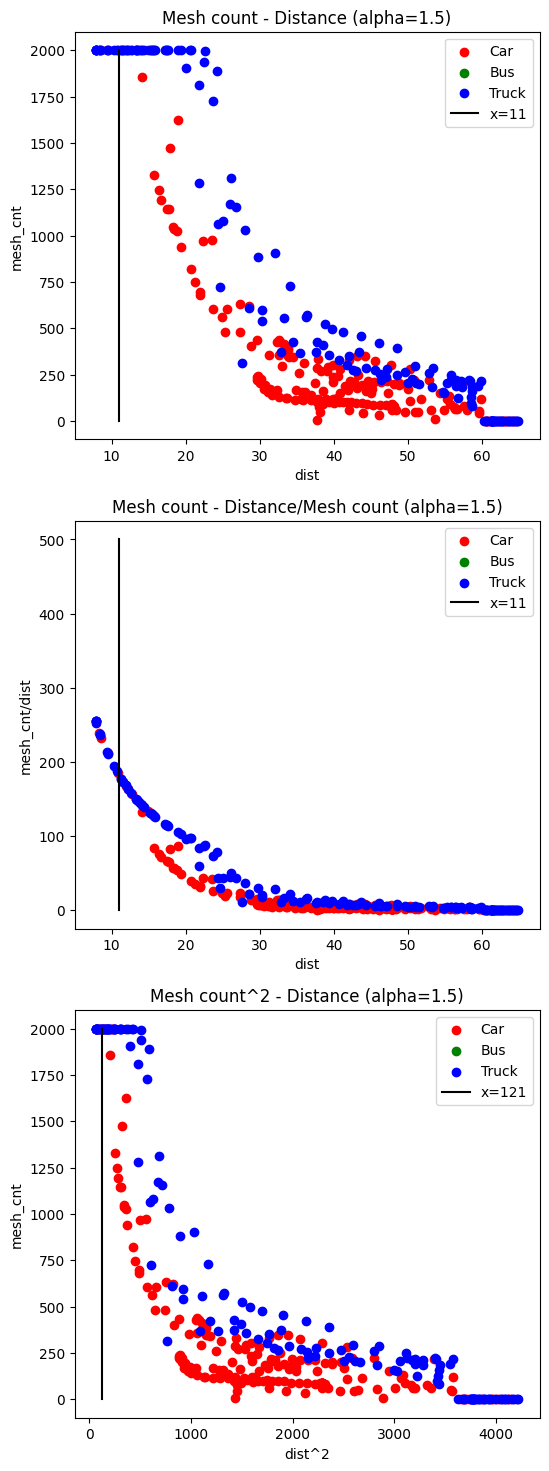

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6, 18))

# Filter the dataframes to only keep points where x < 4000
car_df_filtered = car_df[car_df['dist'] < 65]
bus_df_filtered = bus_df[bus_df['dist'] < 65]
truck_df_filtered = truck_df[truck_df['dist'] < 65]

# max car df mesh_cnt=2000, bus df mesh_cnt=2000, truck df mesh_cnt=2000
# if mesh_cnt > 2000, set it to 2000
car_df_filtered['mesh_cnt'] = car_df_filtered['mesh_cnt'].apply(lambda x: 2000 if x > 2000 else x)
bus_df_filtered['mesh_cnt'] = bus_df_filtered['mesh_cnt'].apply(lambda x: 2000 if x > 2000 else x)
truck_df_filtered['mesh_cnt'] = truck_df_filtered['mesh_cnt'].apply(lambda x: 2000 if x > 2000 else x)

ax1.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt'], c='r', label='Car')
ax1.scatter(bus_df_filtered['dist'], bus_df_filtered['mesh_cnt'], c='g', label='Bus')
ax1.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt'], c='b', label='Truck')
ax1.plot([11, 11], [0, 2000], c='black', label='x=11')
ax1.legend()
ax1.set_title('Mesh count - Distance (alpha=1.5)')
ax1.set_xlabel('dist')
ax1.set_ylabel('mesh_cnt')

ax2.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt']/car_df_filtered['dist'], c='r', label='Car')
ax2.scatter(bus_df_filtered['dist'], bus_df_filtered['mesh_cnt']/bus_df_filtered['dist'], c='g', label='Bus')
ax2.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt']/truck_df_filtered['dist'], c='b', label='Truck')
ax2.plot([11, 11], [0, 500], c='black', label='x=11')
ax2.legend()
ax2.set_title('Mesh count - Distance/Mesh count (alpha=1.5)')
ax2.set_xlabel('dist')
ax2.set_ylabel('mesh_cnt/dist')

ax3.scatter(car_df_filtered['dist']**2, car_df_filtered['mesh_cnt'], c='r', label='Car')
ax3.scatter(bus_df_filtered['dist']**2, bus_df_filtered['mesh_cnt'], c='g', label='Bus')
ax3.scatter(truck_df_filtered['dist']**2, truck_df_filtered['mesh_cnt'], c='b', label='Truck')
ax3.plot([121, 121], [0, 2000], c='black', label='x=121')
ax3.legend()
ax3.set_title('Mesh count^2 - Distance (alpha=1.5)')
ax3.set_xlabel('dist^2')
ax3.set_ylabel('mesh_cnt')

plt.show()


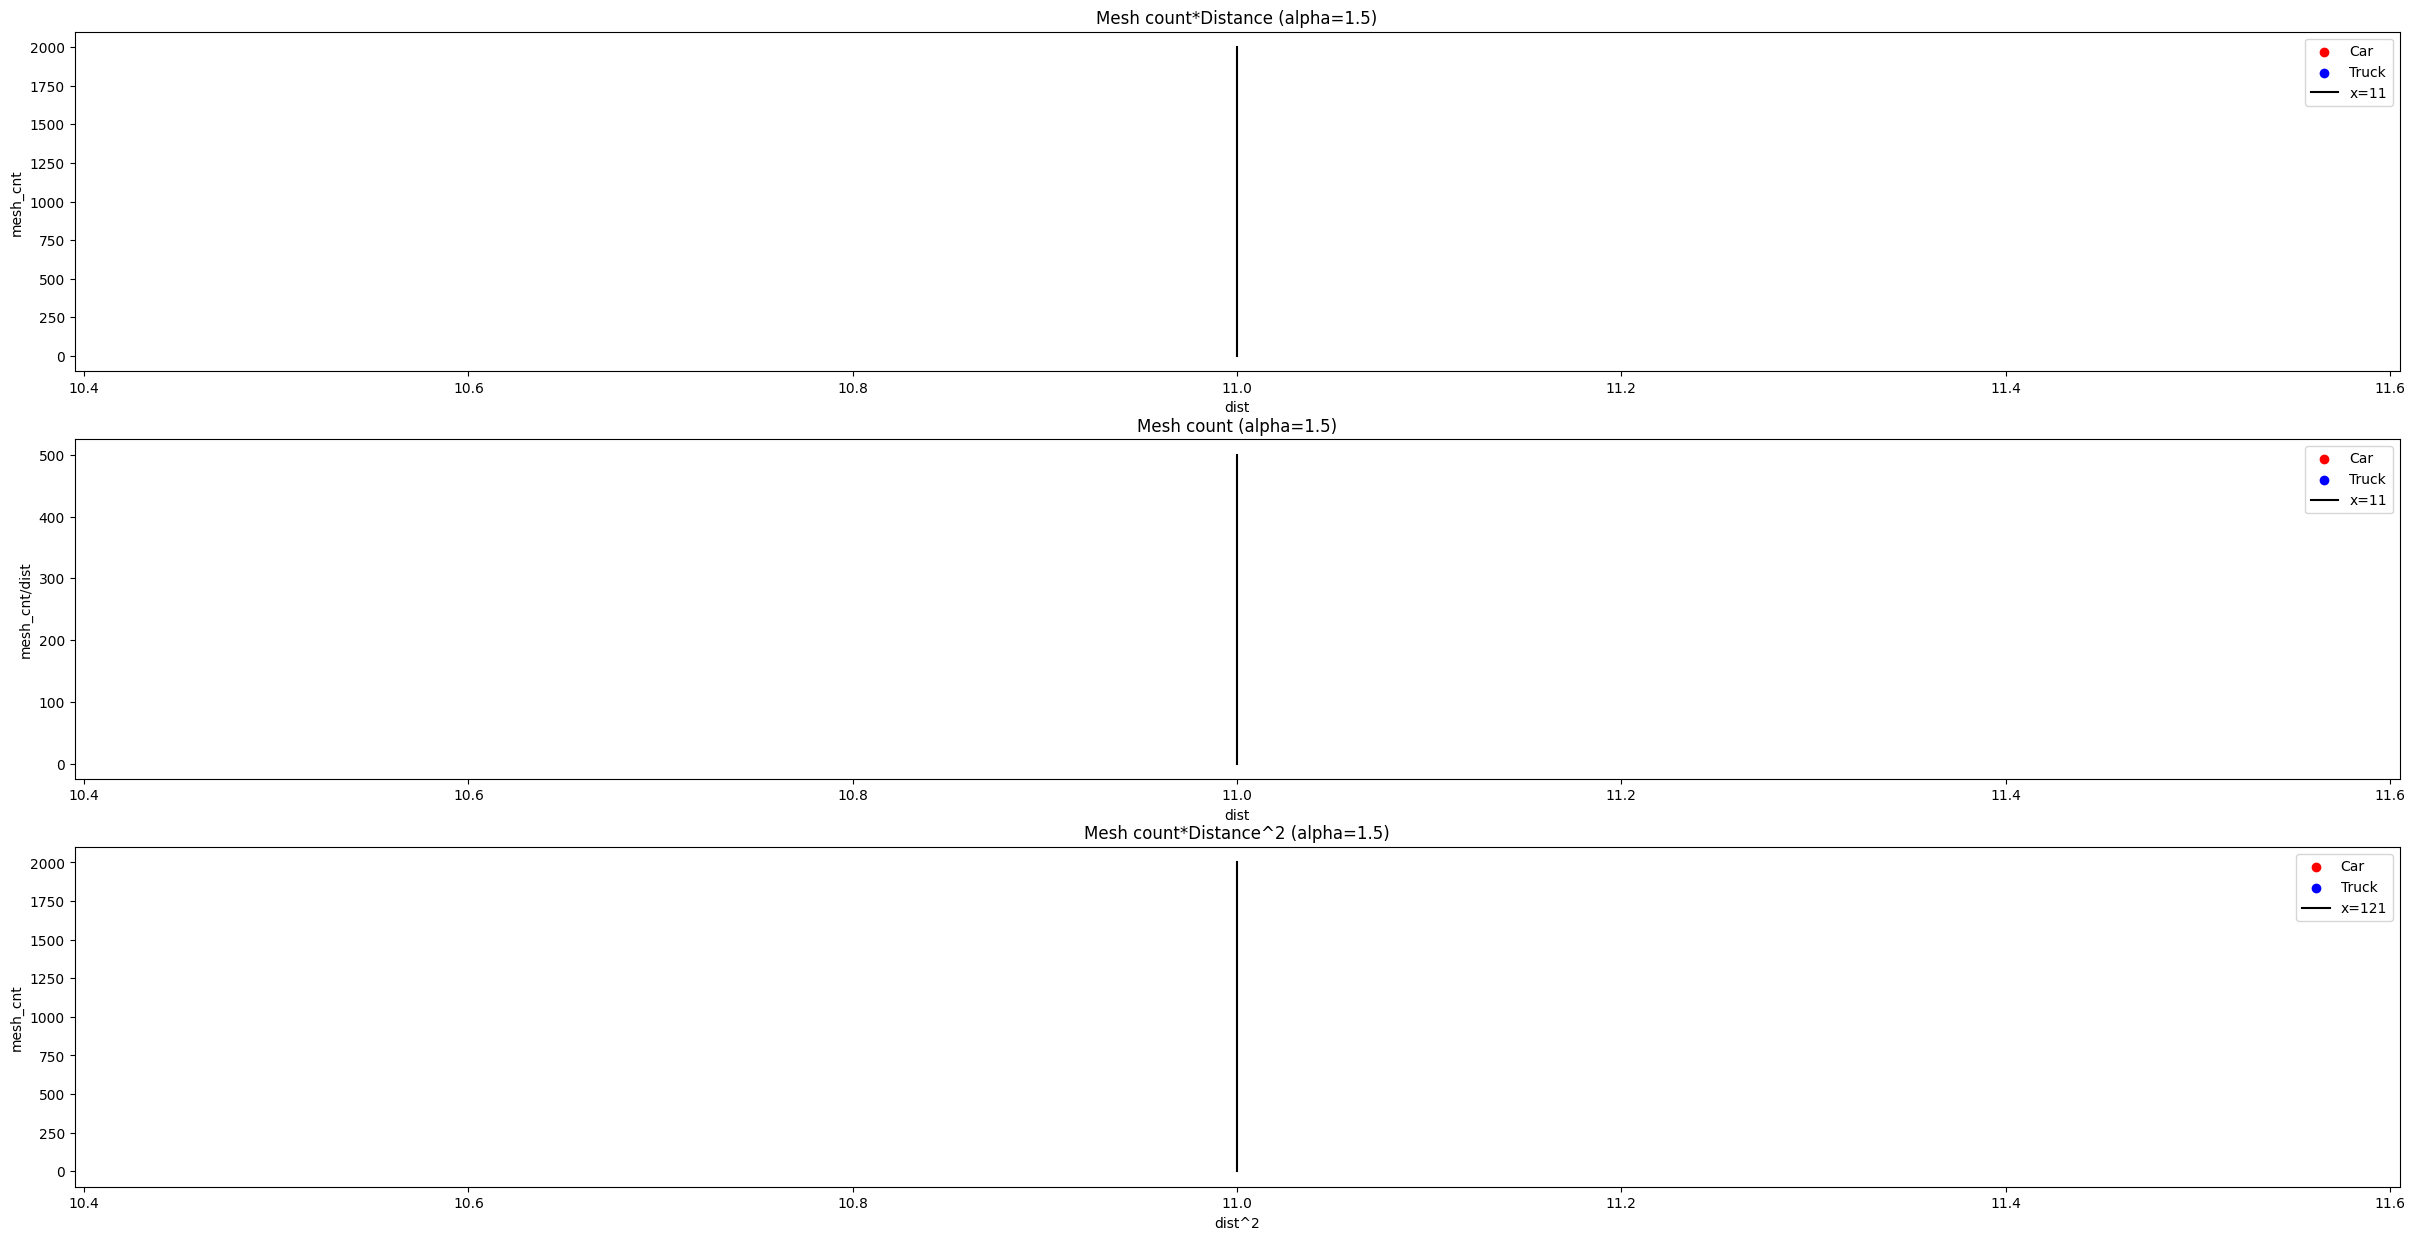

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(30, 15))

# Filter the dataframes to only keep points where x < 4000
car_df_filtered = car_df[car_df['dist'] < 65]
bus_df_filtered = bus_df[bus_df['dist'] < 65]
truck_df_filtered = truck_df[truck_df['dist'] < 65]

ax1.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt'], c='r', label='Car')
ax1.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt'], c='b', label='Truck')
ax1.plot([11, 11], [0, 2000], c='black', label='x=11')
ax1.legend()
ax1.set_title('Mesh count*Distance (alpha=1.5)')
ax1.set_xlabel('dist')
ax1.set_ylabel('mesh_cnt')

ax2.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt']*car_df_filtered['dist'], c='r', label='Car')
ax2.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt']*truck_df_filtered['dist'], c='b', label='Truck')
ax2.plot([11, 11], [0, 500], c='black', label='x=11')
ax2.legend()
ax2.set_title('Mesh count (alpha=1.5)')
ax2.set_xlabel('dist')
ax2.set_ylabel('mesh_cnt/dist')

ax3.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt']*car_df_filtered['dist']**2, c='r', label='Car')
ax3.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt']*truck_df_filtered['dist']**2, c='b', label='Truck')
ax3.plot([11, 11], [0, 2000], c='black', label='x=121')
ax3.legend()
ax3.set_title('Mesh count*Distance^2 (alpha=1.5)')
ax3.set_xlabel('dist^2')
ax3.set_ylabel('mesh_cnt')

plt.show()

1494 477 101


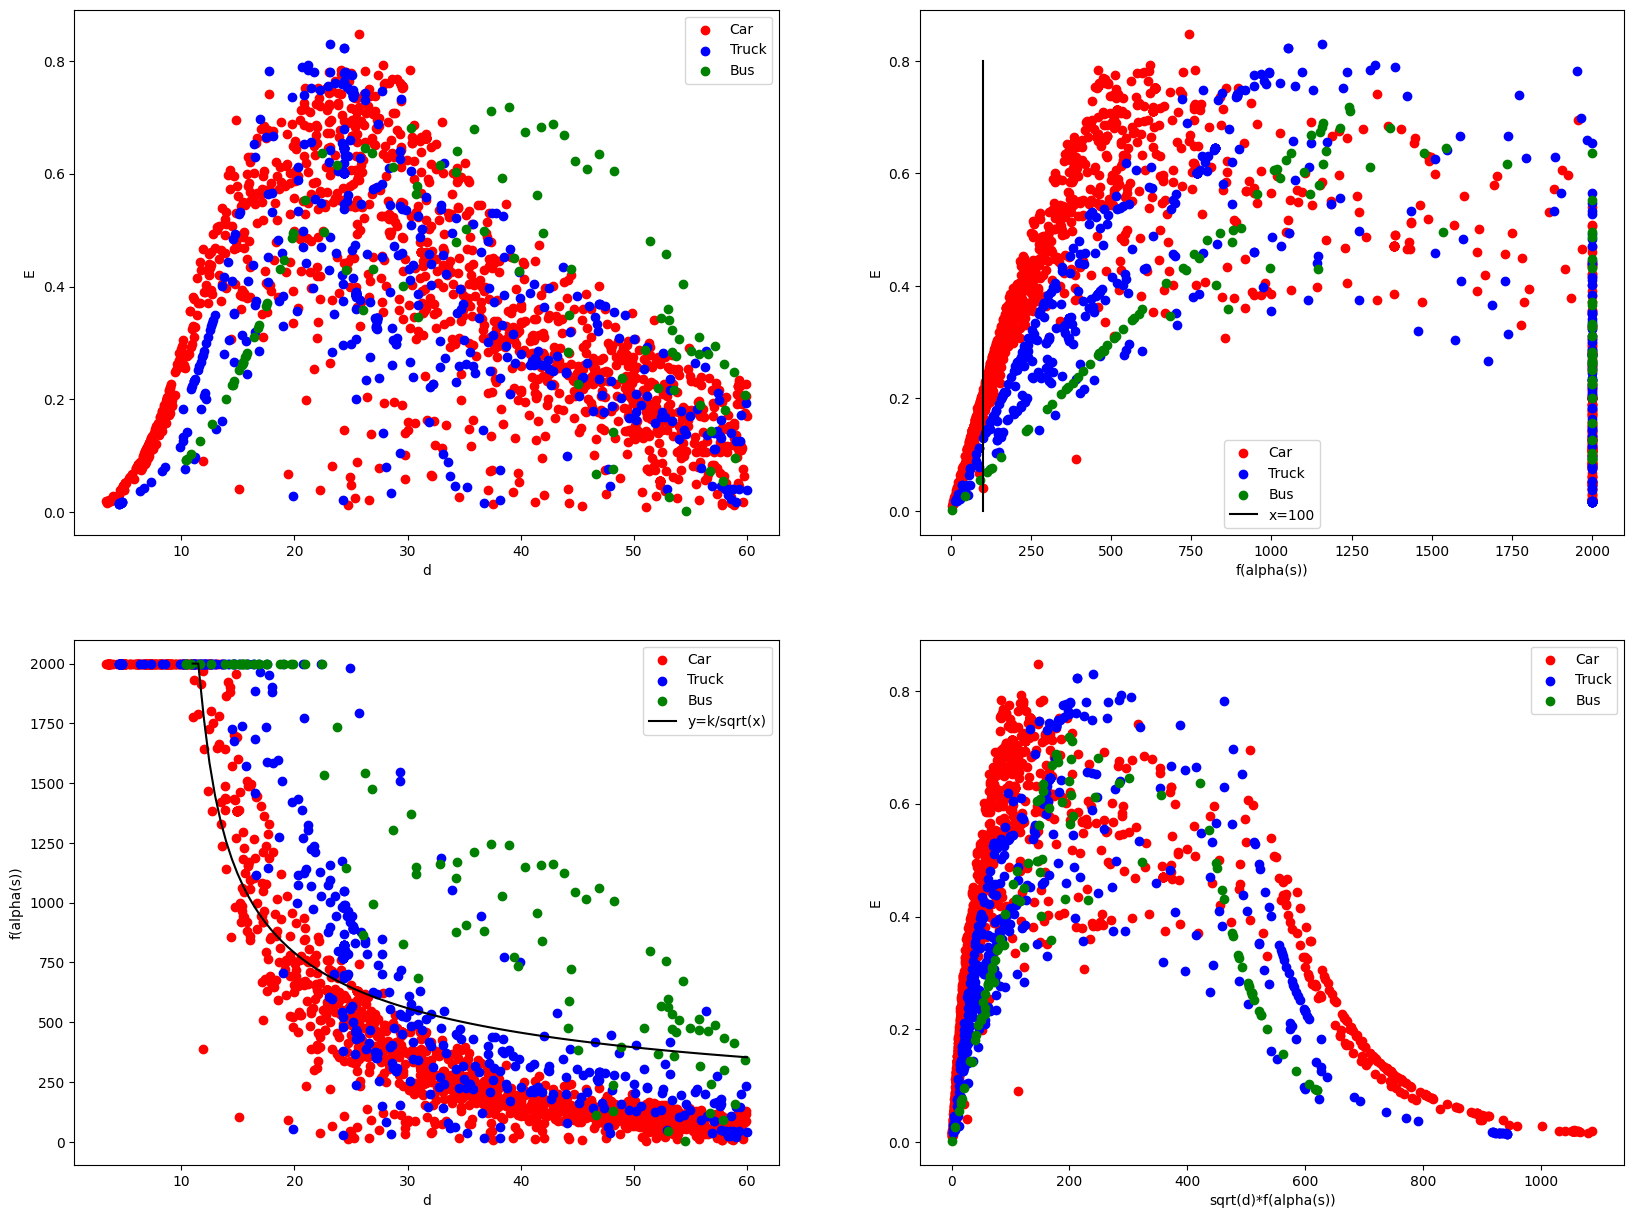

In [11]:
car_df_filtered = car_df[(car_df['dist'] > 0) & (car_df['dist'] <= 60)]
truck_df_filtered = truck_df[(truck_df['dist'] > 0) & (truck_df['dist'] <= 60)]
bus_df_filtered = bus_df[(bus_df['dist'] > 0) & (bus_df['dist'] <= 60)]

x = car_df_filtered['dist'] / 60
yc = 1*(car_df_filtered['dist']**2 * (car_df_filtered['mesh_cnt']) 
    /np.sqrt(car_df_filtered['sx'] * car_df_filtered['sy'] * car_df_filtered['sz'])) /(1e6*(x * np.log(x) + 0.5))
x = truck_df_filtered['dist'] / 60
yt = 0.7*(truck_df_filtered['dist']**2 * (truck_df_filtered['mesh_cnt'])
    /np.sqrt(truck_df_filtered['sx'] * truck_df_filtered['sy'] * truck_df_filtered['sz'])) /(1e6*(x * np.log(x) + 0.5))
x = bus_df_filtered['dist'] / 60
yb = 1.1*(bus_df_filtered['dist']**2 * (bus_df_filtered['mesh_cnt'])
    /np.sqrt(bus_df_filtered['sx'] * bus_df_filtered['sy'] * bus_df_filtered['sz'])) /(1e6*(x * np.log(x) + 0.5))

# x = car_df_filtered['dist'] / 60
# yc = (car_df_filtered['dist']**2 * (car_df_filtered['mesh_cnt']) ) /(1e6*(x * np.log(x) + 0.5))
# x = truck_df_filtered['dist'] / 60
# yt = (truck_df_filtered['dist']**2 * (truck_df_filtered['mesh_cnt'])) /(1e6*(x * np.log(x) + 0.5))
# x = bus_df_filtered['dist'] / 60
# yb = (bus_df_filtered['dist']**2 * (bus_df_filtered['mesh_cnt'])) /(1e6*(x * np.log(x) + 0.5))
# yc[yc > 4.5] = 4.5
# yt[yt > 4.5] = 4.5


# car_df_filtered = car_df_filtered[car_df_filtered['mesh_cnt'] < 2000]
# truck_df_filtered = truck_df_filtered[truck_df_filtered['mesh_cnt'] < 2000]
# bus_df_filtered = bus_df_filtered[bus_df_filtered['mesh_cnt'] < 2000]
# yc = yc[car_df_filtered.index]
# yt = yt[truck_df_filtered.index]
# yb = yb[bus_df_filtered.index]

print(len(yc), len(yt), len(yb))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

ax1.scatter(car_df_filtered['dist'], yc,c='r', label='Car')
ax1.scatter(truck_df_filtered['dist'], yt,c='b', label='Truck')
ax1.scatter(bus_df_filtered['dist'], yb,c='g', label='Bus')

ax1.set_xlabel('d')
ax1.set_ylabel('E')
ax1.legend()

ax2.scatter(car_df_filtered['mesh_cnt'], yc,c='r', label='Car')
ax2.scatter(truck_df_filtered['mesh_cnt'], yt,c='b', label='Truck')
ax2.scatter(bus_df_filtered['mesh_cnt'], yb,c='g', label='Bus')
ax2.plot([100, 100], [0, 0.8], c='black', label='x=100')

ax2.set_xlabel('f(alpha(s))')
ax2.set_ylabel('E')
ax2.legend()

ax3.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt'],c='r', label='Car')
ax3.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt'],c='b', label='Truck')
ax3.scatter(bus_df_filtered['dist'], bus_df_filtered['mesh_cnt'],c='g', label='Bus')
# draw y = ln(x) in ax3
xx = np.linspace(11, 60, 100)
# yy = 500*(-np.log(xx-10))+2000
yy = 2500/(xx-10)**0.5
yy[yy > 2000] = 2000
ax3.plot(xx, yy, c='black', label='y=k/sqrt(x)')
ax3.set_xlabel('d')
ax3.set_ylabel('f(alpha(s))')
ax3.legend()

# car_df_filtered = car_df_filtered[car_df_filtered['mesh_cnt'] < 500]
# truck_df_filtered = truck_df_filtered[truck_df_filtered['mesh_cnt'] < 500]
# bus_df_filtered = bus_df_filtered[bus_df_filtered['mesh_cnt'] < 500]
# yc = yc[car_df_filtered.index]
# yt = yt[truck_df_filtered.index]
# yb = yb[bus_df_filtered.index]

p_mc = (car_df_filtered['mesh_cnt'])/(np.sqrt(car_df_filtered['dist']))
p_mt = (truck_df_filtered['mesh_cnt'])/(np.sqrt(truck_df_filtered['dist']))
p_mb = (bus_df_filtered['mesh_cnt'])/(np.sqrt(bus_df_filtered['dist']))


ax4.scatter(p_mc, yc,c='r', label='Car')
ax4.scatter(p_mt, yt,c='b', label='Truck')
ax4.scatter(p_mb, yb,c='g', label='Bus')


ax4.set_xlabel('sqrt(d)*f(alpha(s))')
ax4.set_ylabel('E')
ax4.legend()

plt.show()


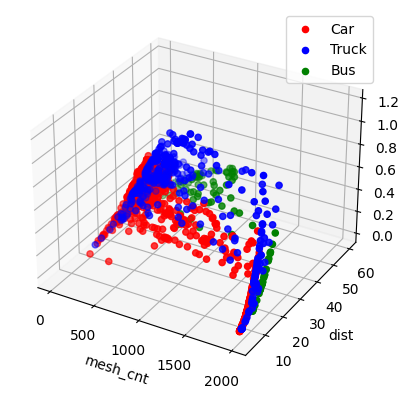

In [ ]:
# draw 3d plot, (mesh_cnt, dist, E)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(car_df_filtered['mesh_cnt'], car_df_filtered['dist'], yc,c='r', label='Car')
ax.scatter(truck_df_filtered['mesh_cnt'], truck_df_filtered['dist'], yt,c='b', label='Truck')
ax.scatter(bus_df_filtered['mesh_cnt'], bus_df_filtered['dist'], yb,c='g', label='Bus')
ax.set_xlabel('mesh_cnt')
ax.set_ylabel('dist')
ax.set_zlabel('E')
ax.legend()
plt.show()

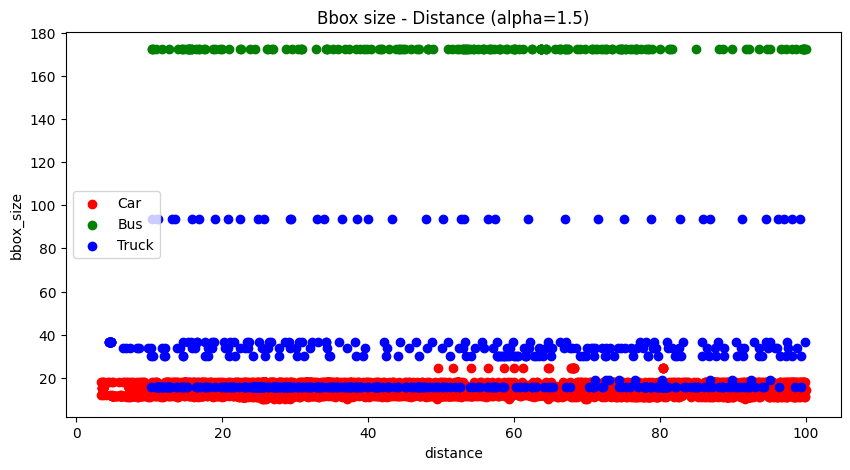

In [ ]:
car_bbox_size = car_df['sx'] * car_df['sy'] * car_df['sz']
bus_bbox_size = bus_df['sx'] * bus_df['sy'] * bus_df['sz']
truck_bbox_size = truck_df['sx'] * truck_df['sy'] * truck_df['sz']

# visualize the bbox size of each tag
plt.figure(figsize=(10, 5))
plt.scatter(car_df['dist'], car_bbox_size, c='r', label='Car')
plt.scatter(bus_df['dist'], bus_bbox_size, c='g', label='Bus')
plt.scatter(truck_df['dist'], truck_bbox_size, c='b', label='Truck')
plt.legend()
plt.title('Bbox size - Distance (alpha=1.5)')
plt.xlabel('distance')
plt.ylabel('bbox_size')
plt.show()